In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

### Import & Clean Road data / Routes / GTFS realtime points Data


<Axes: >

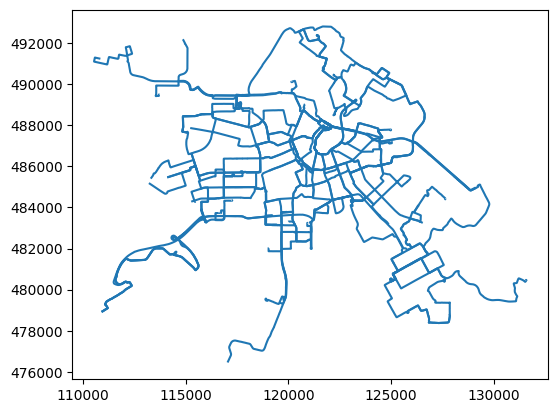

In [ ]:
# add roads god 
routes_ams = gpd.read_file('data/public_transport.gpkg')


In [3]:
# add interpolated_GVB_1503_gdf_1102.0_GVB.shp 
interpolated_GVB_1503_gdf = gpd.read_file('interpolated_GVB_1503_gdf.shp')

#### Working Algorith snapping - however slow for routes

### It works PAPER *** 

Approach was made snapping to closest route differenitated by trams and buses routes, snapping to exact route was too complex for algorithm and potenitally problematic due to crutial mistakes, this way we allign to the closest line in the network of routes. 

### FINAL FUNCTION

#### INPUT DATA: Public Transport Data Lines City 
#### INPUT DATA: Interpolated Realtime Data Agency Time 
#### OUTPUT DATA: Snapped Realtime Data Agency Time

In [5]:
def snap_interpolated_points_to_routes(routes_gdf: gpd.GeoDataFrame, interpolated_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Snap interpolated GTFS points (buses and trams) to their nearest GVB route lines in Amsterdam.

    Parameters:
    - routes_gdf         : GeoDataFrame of public transport routes (must include 'route_type')
    - interpolated_gdf   : GeoDataFrame of interpolated GTFS points (must include 'route_type', 'geometry')

    Returns:
    - GeoDataFrame of snapped GTFS points (deduplicated), projected in same CRS as routes_gdf
    """

    # Reproject interpolated data to match routes CRS
    interpolated_gdf = interpolated_gdf.to_crs(routes_gdf.crs)

    # Split by mode
    interpolated_trams = interpolated_gdf[interpolated_gdf['route_type'] == 0]
    interpolated_buses = interpolated_gdf[interpolated_gdf['route_type'] == 3]

    routes_trams = routes_gdf[routes_gdf['route_type'] == 0]
    routes_buses = routes_gdf[routes_gdf['route_type'] == 3]

    # Plot raw data
    fig, ax = plt.subplots(figsize=(10, 10))
    routes_gdf.plot(ax=ax, color='black', linewidth=0.5)
    interpolated_gdf.plot(ax=ax, color='red', linewidth=0.5, markersize=0.2)
    plt.title('Routes and Interpolated GTFS Points')

    def snap_points(points_gdf, lines_gdf):
        joined = gpd.sjoin_nearest(points_gdf, lines_gdf, how="inner", distance_col="dist")
        snapped = []
        for i, row in joined.iterrows():
            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1} values")
            road = lines_gdf.loc[int(row['index_right'])].geometry
            proj = road.project(row.geometry)
            snapped_point = road.interpolate(proj)
            snapped.append(snapped_point)
        joined['geometry'] = snapped
        return joined.drop(columns=['index_right', 'dist'])

    # Snap trams
    final_trams = snap_points(interpolated_trams, routes_trams)
    final_trams = final_trams[['new_timest', 'new_lat', 'new_lon', 'uni_id', 'route_id_left', 'trip_id', 'route_type_left', 'geometry']]

    # Snap buses
    final_buses = snap_points(interpolated_buses, routes_buses)
    final_buses = final_buses[['new_timest', 'new_lat', 'new_lon', 'uni_id', 'route_id_left', 'trip_id', 'route_type_left', 'geometry']]

    # Combine
    snapped = gpd.GeoDataFrame(pd.concat([final_buses, final_trams], ignore_index=True), crs=routes_gdf.crs)

    # Drop duplicates
    snapped = snapped.drop_duplicates(subset=['new_lat', 'new_lon', 'new_timest', 'uni_id'], keep='first')

    # Plot snapped
    fig, ax = plt.subplots(figsize=(10, 10))
    routes_gdf.plot(ax=ax, color='black', linewidth=0.5)
    snapped.plot(ax=ax, color='red', linewidth=0.5, markersize=0.2)
    plt.title('Roads and Snapped GTFS Points')

    return snapped

Processed 949000 values
Processed 950000 values
Processed 950000 values
Processed 951000 values
Processed 951000 values
Processed 952000 values
Processed 953000 values
Processed 954000 values
Processed 955000 values
Processed 956000 values
Processed 957000 values
Processed 957000 values
Processed 958000 values
Processed 959000 values
Processed 960000 values
Processed 961000 values
Processed 962000 values
Processed 963000 values
Processed 964000 values
Processed 965000 values
Processed 966000 values
Processed 967000 values
Processed 968000 values
Processed 969000 values
Processed 970000 values
Processed 970000 values
Processed 971000 values
Processed 972000 values
Processed 973000 values
Processed 974000 values
Processed 975000 values
Processed 976000 values
Processed 977000 values
Processed 978000 values
Processed 978000 values
Processed 979000 values
Processed 979000 values
Processed 980000 values
Processed 981000 values
Processed 982000 values
Processed 983000 values
Processed 984000

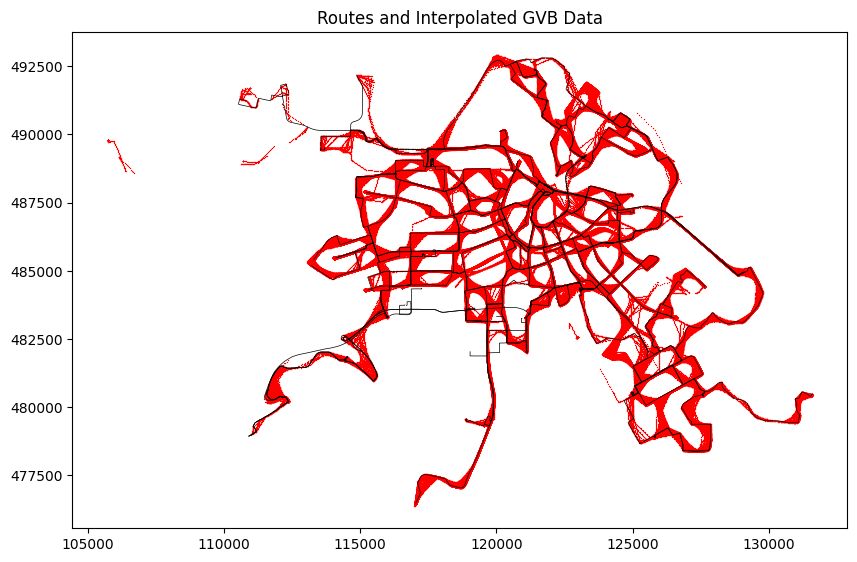

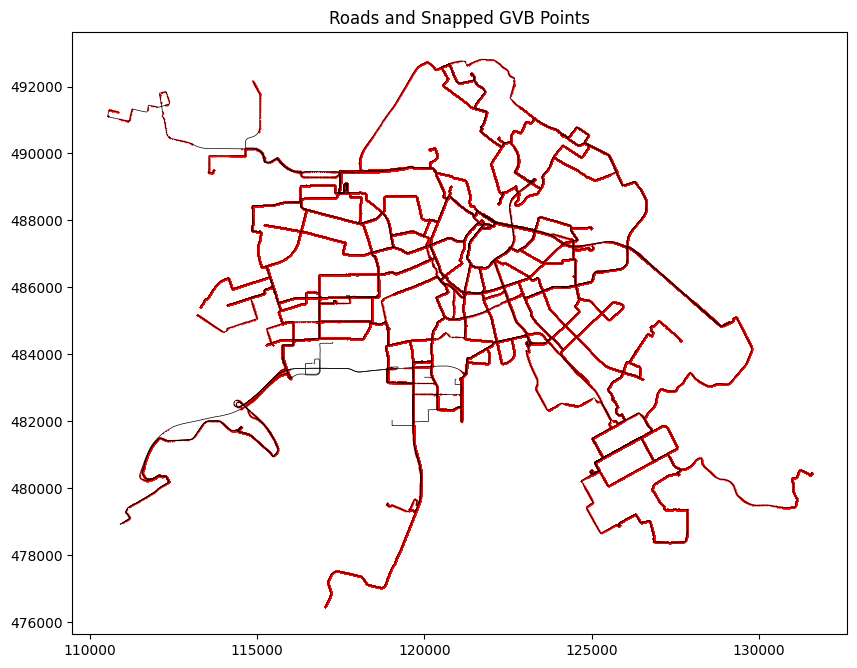

In [4]:
# Usage 

routes = gpd.read_file("data/public_transport.gpkg")
interpolated = gpd.read_file("interpolated_GVB_1503_gdf.shp")

snapped_realtime = snap_interpolated_points_to_routes(routes, interpolated)

In [6]:
len(snapped_realtime)

2741836